# 数据集大小 
为了理解 两个因素对拟合和过拟合的影响，我们来动个手 

# 多项式拟合 

我们以多项式为例。给定一个标量数据点集合X和对应的目标值y,多项式拟合的目标是找一个K阶多项式。然后和这个多项式进行匹配。其由向量W和位移B组成，来最好地近似每个样本x和y.
用数学符号来表示就是我们用 w和b来预测 

并以平方差为损失函数。特别地，一阶多项式拟合又叫 线性拟合 。

# 创建数据集 

这里我们使用一个人工数据来把事情弄简单些，因为这样我们将置到真实的模型是什么样子的。
具体来说，我们使用如下的二阶多项式来生成每一个数据样本。 
这里噪音服从均值0和标准差为 0.1的正态分布。 
需要注意的是，我们用以上相同的数据生成函数来生成训练集和测试数据集 。
两个数据集的样本数都是100. 


In [11]:
from mxnet import ndarray as nd 
from mxnet import autograd 
from mxnet import gluon
import mxnet as mx 

num_train=100
num_test=100 
true_w =[1.2,-3.4,5.6]
true_b =5.0 


下面生成数据集 

In [37]:
x=nd.random.normal(shape=(num_train+num_test,1)) 
X=nd.concat(x,nd.power(x,2),nd.power(x,3)) 
y=true_w[0]*X[:,0]+true_w[1]*X[:,1]+true_w[2]*X[:,2]+true_b 
y+=0.1*nd.random.normal(shape=y.shape) 
y_train,y_test=y[:num_train],y[num_train:]

('x:',x[:5],'X:',X[:5],'y:',y[:5])

('x:',
 
 [[ 0.6008336 ]
  [-0.8230541 ]
  [-0.23689993]
  [-0.0149263 ]
  [ 0.38457626]]
 <NDArray 5x1 @cpu(0)>,
 'X:',
 
 [[ 6.0083359e-01  3.6100101e-01  2.1690154e-01]
  [-8.2305408e-01  6.7741799e-01 -5.5755168e-01]
  [-2.3689993e-01  5.6121577e-02 -1.3295197e-02]
  [-1.4926301e-02  2.2279446e-04 -3.3254973e-06]
  [ 3.8457626e-01  1.4789890e-01  5.6878407e-02]]
 <NDArray 5x3 @cpu(0)>,
 'y:',
 
 [ 5.731169  -1.3920325  4.5790977  5.0921607  5.2902613]
 <NDArray 5 @cpu(0)>)

In [7]:
%matplotlib inline 
import matplotlib as mpl 

In [8]:
mpl.rcParams['figure.dpi']=120
import matplotlib.pyplot as plt 

In [9]:
def test(net,X,y):
    return square_loss(net(X),y).mean().asscalar() 

In [32]:
def train (X_train,X_test,y_train,y_test):
    # 线性回归模型 
    net=gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize() 
    # 设一些默认参数 
    learning_rate=0.001
    epochs=100 
    # batch_size = min(1,y_train.shape[0]) 
    batch_size=10 
    dataset_train =gluon.data.ArrayDataset(X_train,y_train) 
    data_iter_train=gluon.data.DataLoader(dataset_train,batch_size,shuffle=True) 
    # 默认SGD和均方误差　
    trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':learning_rate})
    square_loss=gluon.loss.L2Loss() 
    # 保存训练和测试损失 
    train_loss=[]
    test_loss=[]
    for e in range(epochs):
        for data,label in data_iter_train:
            with autograd.record(): 
                output=net(data) 
                loss=square_loss(output,label) 
            loss.backward() 
            trainer.step(batch_size)
        train_loss.append(square_loss(net(X_train),y_train).mean().asscalar()) 
        test_loss.append(square_loss(net(X_test),y_test).mean().asscalar()) 
  #打印结果  
    plt.plot(train_loss)
    plt.plot(test_loss) 
    plt.legend(['train','test'])
    plt.show() 
    return ('learned weight',net[0].weight.data(),'learned bias',net[0].bias.data())
        

# 三阶多项式拟合（正常)
我们先使用与数据生成函数同阶的三阶多项式拟合。实验表明这个模型的训练误差和在测试数据集的
误差都比较低。训练出的模型参数也接近真实值 

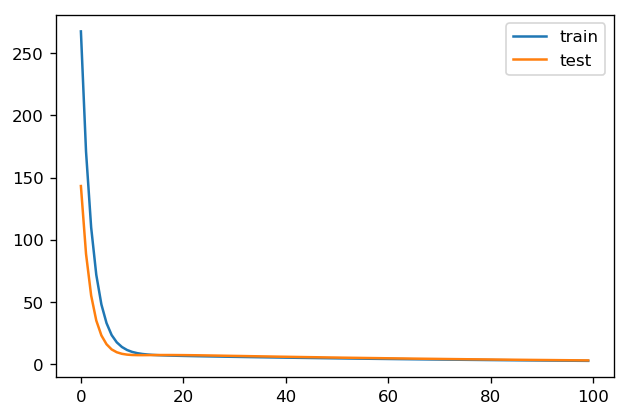

('learned weight',
 
 [[ 0.8733902 -2.1872644  5.8252015]]
 <NDArray 1x3 @cpu(0)>,
 'learned bias',
 
 [1.9875242]
 <NDArray 1 @cpu(0)>)

In [33]:
train(X[:num_test,:],X[num_train:,:],y[:num_train],y[num_train:]) 

# 线性拟合（欠拟合） 
我们再试试线性拟合。很明显，该模型的训练误差很高。线性模型在非线性模型（例如三阶多项式）生成的数据集上容易欠拟合。

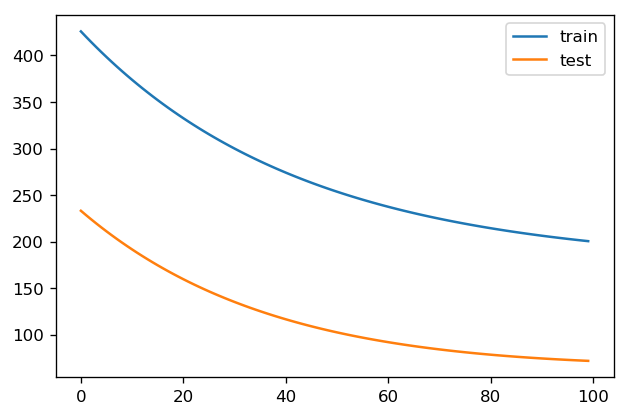

('learned weight',
 
 [[14.415206]]
 <NDArray 1x1 @cpu(0)>,
 'learned bias',
 
 [-0.32166347]
 <NDArray 1 @cpu(0)>)

In [34]:
train(x[:num_train,:],x[num_train:,:],y[:num_train],y[num_train:])

# 训练量不足（过拟合） 
事实上，即使是使用与数据生成模型同阶的三阶多项式模型，如果训练量不足，该模型依然容易过拟合，让我们仅仅使用两个训练样本来训练。很显示，训练样本过少了。甚至少于模型参数的数量。这使得模型显得过于复杂，以至于容易被训练数据集中的噪声影响。在机器学习过程中，即便训练误差很低，但是测试数据集上的误差很高。这是典型的过拟合现象。 


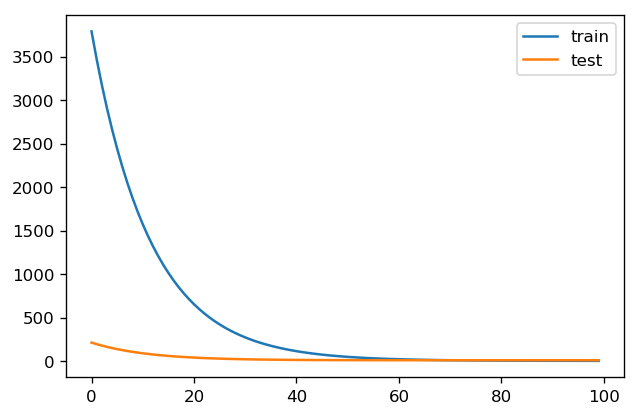

('learned weight',
 
 [[ 0.9300686 -2.16479    5.69675  ]]
 <NDArray 1x3 @cpu(0)>,
 'learned bias',
 
 [-0.34787747]
 <NDArray 1 @cpu(0)>)

In [36]:
train(X[0:2,:],X[num_train:,:],y[0:2],y[num_train:]) 